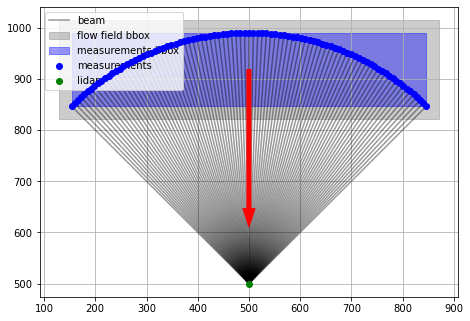

In [22]:
import mocalum as mc
import numpy as np
import xarray as xr

koshava_xyz = np.array([500, 500, 0])
no_scans = 10000
# wind field setup
ref_height = 100      # power law reference height
meas_height = 100 
shear_exponent = 0.2  # power law shear exponent
wind_speed = 8       # wind speed at referenec height
wind_dir = 0 # wind direction
w = 0 

# beam steering setup
distance = 500   # meter
elevation = np.degrees(np.arcsin(meas_height / distance))
angular_res = 1   # degree
azimuth_mid = 45  # central azimuth angle
sector_size = 90  # degree
scan_speed = 1    # degree.s^-1
max_speed = 50    # degree.s^-1
max_acc = 100     # degree.s^-2

# Uncertainty terms
# no_sim = 10000 # number of simulations
corr_coef = 0  # correlation coefficient
mu = 0         # we assume no systematic uncertainty
azim_std = 0.1 # degrees
elev_std = 0.1 # degrees
dis_std = 10   # meters
rad_std = 0.1  # m.s-1  In [23]:  
pl_mc = mc.Mocalum()
pl_mc.add_lidar('sterenn', koshava_xyz)
pl_mc.add_lidar('koshava', koshava_xyz)

pl_mc.set_ivap_probing('koshava', sector_size, wind_dir, angular_res, elevation, distance, 
                    no_scans, scan_speed, max_speed,max_acc)

#pl_mc.set_ivap_probing('sterenn', sector_size*2, azimuth_mid, angular_res, elevation, distance, 
#                    no_scans, scan_speed, max_speed,max_acc)
#pl_mc.data.probing['koshava']

pl_mc.gen_plaw_ffield('koshava',wind_speed, wind_dir, w, ref_height, shear_exponent)
mc.plot_mocalum_setup('koshava', 'koshava',pl_mc)


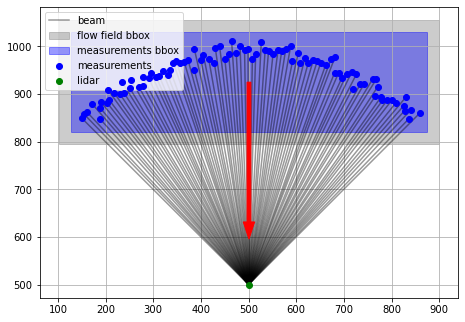

<xarray.Dataset>
Dimensions:      (time: 910000)
Coordinates:
  * time         (time) float64 0.0 1.0 2.0 3.0 ... 9.23e+05 9.23e+05 9.23e+05
Data variables:
    az           (time) float64 -45.0 -44.0 -43.0 -42.0 ... 42.0 43.0 44.0 45.0
    el           (time) float64 11.54 11.54 11.54 11.54 ... 11.54 11.54 11.54
    rng          (time) float64 500.0 500.0 500.0 500.0 ... 500.0 500.0 500.0
    x            (time) float64 150.1 154.4 161.1 187.6 ... 830.3 832.7 858.7
    y            (time) float64 849.1 857.9 861.7 848.3 ... 852.4 845.2 858.5
    z            (time) float64 101.9 101.4 100.9 96.59 ... 98.94 97.03 103.6
    unc_az       (time) float64 -0.06969 0.004343 -0.1366 ... -0.06092 0.0148
    unc_el       (time) float64 0.1075 -0.0166 -0.03351 ... -0.09604 0.003681
    unc_rng      (time) float64 4.673 7.753 5.853 -22.25 ... -6.981 -10.82 17.66
    unc_est      (time) float64 0.0008458 -0.1238 -0.1332 ... 0.03343 -0.0223
    sectrsz      int64 90
    no_scans     int64 10000
    no_los       int64 91
    scan_tm      int64 90
    return_tm    float64 2.3
    lidar_pos_x  int64 500
    lidar_pos_y  int64 500
    lidar_pos_z  int64 0
Attributes:
    title:    Lidar atmosphere probing dataset

In [23]:
pl_mc.gen_unc_contributors('koshava')

pl_mc.gen_plaw_ffield('koshava',wind_speed, wind_dir, w, ref_height, shear_exponent)
mc.plot_mocalum_setup('koshava', 'koshava',pl_mc)
pl_mc.data.probing['koshava']


In [24]:
pl_mc.gen_turb_ffield('koshava',wind_speed, wind_dir, w, ref_height, shear_exponent)

In [25]:
pl_mc._calc_los_speed('koshava', 'turb_for_koshava')

In [26]:
pl_mc.reconstruct_wind('koshava')

In [28]:
pl_mc.data.ffield_bbox_cfg

{'koshava': {'CRS': {'x': 'Absolute coordinate, coresponds to Easting in m',
   'y': 'Absolute coordinate, coresponds to Northing in m',
   'z': 'Absolute coordinate, coresponds to height above sea level in m',
   'rot_matrix': array([[ 1.,  0.],
          [-0.,  1.]])},
  'x': {'min': 101.48196807222234,
   'max': 899.8628412085677,
   'offset': 0,
   'res': 25},
  'y': {'min': 794.3138125769456,
   'max': 1055.211264410292,
   'offset': 0,
   'res': 25},
  'z': {'min': 84.90159511655311,
   'max': 115.71611206307396,
   'offset': 0,
   'res': 5},
  't': {'min': 0.0, 'max': 922997.7, 'offset': 0, 'res': 1.01428430141132}},
 'turb_for_koshava': {'CRS': {'x': 'Relative coordinate, use inv(rot_matrix) to convert to abs',
   'y': 'Relative coordinate, use inv(rot_matrix) to convert to abs',
   'z': 'Absolute coordinate, coresponds to height above sea level',
   'rot_matrix': array([[ 6.123234e-17, -1.000000e+00],
          [ 1.000000e+00,  6.123234e-17]])},
  'x': {'min': 819.313812576945

In [5]:
lidar_id = 'koshava'
bbox_id = 'turb_for_koshava'


# Normalize time to re-feed the turbulence
time_prob = pl_mc.data.probing[lidar_id].time.values
time_tbox = pl_mc.data.ffield.time.values
time_norm = np.mod(time_prob, time_tbox.max())

# Rotate relative coordinates to absolute coordinates
R_tb = pl_mc.data.ffield_bbox_cfg[bbox_id]['CRS']['rot_matrix']
x = pl_mc.data.probing[lidar_id].x.values
y = pl_mc.data.probing[lidar_id].y.values
z_coords = pl_mc.data.probing[lidar_id].z.values
xy = np.array([x,y]).T.dot(R_tb)
x_coords = xy[:,0]
y_coords = xy[:,1]

In [22]:
import time


"the code you want to test stays here"


In [106]:
start = time.time()
no_los = 1000

# pl_mc.data.ffield.u.interp(time = time_norm[:no_scans*no_los],
#                            x = x_corrds[:no_scans*no_los],
#                            y = y_corrds[:no_scans*no_los])

# pl_mc.data.ffield.u.interp(time = time_norm,x=x_corrds)


# u_interp_1 = pl_mc.data.ffield.u.interp(time = time_norm[:no_los], 
#                                       x = x_corrds[:no_los],
#                                       y = y_corrds[:no_los],
#                                       z = z_corrds[:no_los])

end = time.time()
print(end - start)

0.0001201629638671875


In [111]:
t = xr.DataArray(time_norm, dims='pt')
x = xr.DataArray(x_corrds, dims='pt')
y = xr.DataArray(y_corrds, dims='pt')
z = xr.DataArray(z_corrds, dims='pt') 

interpolated = pl_mc.data.ffield.interp(time=t, x=x, y=y, z=z, method='linear')

In [119]:
interpolated.u[:10]

<xarray.DataArray 'u' (pt: 10)>
array([-2.29551037, -2.30694854, -2.47500077, -2.30173596, -3.31140601,
       -3.23707428, -1.58115875, -1.46439307, -1.56296013, -2.55179336])
Coordinates:
    Easting   (pt) float64 973.1 977.1 978.6 980.5 ... 993.5 996.6 987.2 967.7
    Northing  (pt) float64 624.9 617.2 609.4 602.2 ... 578.7 569.3 560.1 549.7
    Height    (pt) float64 99.85 101.4 99.99 102.1 ... 101.7 101.4 100.9 97.5
    time      (pt) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
    x         (pt) float64 920.0 914.1 907.4 901.2 ... 883.5 875.8 864.0 847.5
    y         (pt) float64 -700.6 -707.1 -711.2 -715.4 ... -741.8 -736.1 -721.3
    z         (pt) float64 99.85 101.4 99.99 102.1 ... 101.7 101.4 100.9 97.5
Dimensions without coordinates: pt
Attributes:
    long_name:      Eastward wind
    standard_name:  eastward_wind
    units:          m.s-1
    URI:

In [110]:
u_interp_3

array([-2.29551037, -2.30694854, -2.47500077, -2.30173596, -3.31140601,
       -3.23707428, -1.58115875, -1.46439307, -1.56296013, -2.55179336,
       -1.07811133, -1.49314206,  0.0190908 , -1.1020096 , -1.21754898,
       -1.41420683, -1.47408348, -1.44456919, -0.89559441, -1.62694624,
       -1.87632232, -1.48036677, -1.56514018, -1.76759135, -2.3494905 ,
       -1.84265446, -1.61015535, -2.00556676, -2.37520516, -1.61546627,
       -2.2235931 , -3.6714121 , -3.49009197, -3.68159882, -3.60927725,
       -3.3246118 , -2.63142731, -2.67023727, -2.84517781, -1.76231044,
       -1.90411053, -1.48888047, -1.69797773, -1.89117502, -1.98015658,
       -2.29792165, -2.39608252, -2.09218149, -1.08909338, -1.5848363 ])

In [113]:
interpolated

<xarray.Dataset>
Dimensions:   (pt: 31000)
Coordinates:
    Easting   (pt) float64 973.1 977.1 978.6 980.5 ... 978.9 965.3 979.3 977.1
    Northing  (pt) float64 624.9 617.2 609.4 602.2 ... 397.6 392.5 379.7 371.7
    Height    (pt) float64 99.85 101.4 99.99 102.1 ... 100.2 98.36 101.4 99.78
    time      (pt) float64 0.0 1.0 2.0 3.0 4.0 ... 157.4 158.4 159.4 160.4 161.4
    x         (pt) float64 920.0 914.1 907.4 901.2 ... 708.4 699.0 691.8 683.4
    y         (pt) float64 -700.6 -707.1 -711.2 -715.4 ... -772.9 -790.4 -791.0
    z         (pt) float64 99.85 101.4 99.99 102.1 ... 100.2 98.36 101.4 99.78
Dimensions without coordinates: pt
Data variables:
    u         (pt) float64 -2.296 -2.307 -2.475 -2.302 ... -2.676 -3.349 -3.672
    v         (pt) float64 -6.518 -5.848 -5.68 -5.2 ... -7.48 -8.373 -8.297
    w         (pt) float64 0.7719 0.3152 0.06045 ... -0.1202 -1.802 -1.613
Attributes:
    generator:  PyConTurb
    title:      Turbulent flow field dataset

In [ ]:

t_n = data.ffield.u(ti, dims='pt')
x_n = data.ffield.u(x, dims='pt')
y_n = data.ffield.u(y, dims='pt')
z_n = data.ffield.u(z, dims='pt')
interpolated = ds.interp(t=t, x=x, y=y, z=z, method='linear')


In [88]:
start = time.time()
no_los = 50

u_interp_2 = pl_mc.data.ffield.u.interp(time = time_norm[:no_los]).interp(x = x_corrds[:no_los]).interp(y = y_corrds[:no_los]).interp(z = z_corrds[:no_los])


end = time.time()
print(end - start)

0.32385993003845215


In [89]:
start = time.time()
u_interp_3 = np.empty(no_los)
for i in range(0, no_los):
    u_interp_3[i] = pl_mc.data.ffield.u.interp(time = time_norm[i], 
                                      x = x_corrds[i],
                                      y = y_corrds[i],
                                      z = z_corrds[i])
end = time.time()
print(end - start)    

1.3409810066223145


In [26]:
#time = pl_mc.data.probing['koshava'].time
x_corrds = pl_mc.data.probing['koshava'].x
y_corrds = pl_mc.data.probing['koshava'].y
z_corrds = pl_mc.data.probing['koshava'].z
#time_ = pl_mc.data.probing['koshava'].time

# time_norm = np.mod(pl_mc.data.probing['koshava'].time, t_box_l)

no_scans = 1
no_los = 61

# trt =pl_mc.data.ffield.interp(t = time[:no_scans*no_los], 
#                          x = x_corrds[:no_scans*no_los],
#                          y = y_corrds[:no_scans*no_los],
#                          z = z_corrds[:no_scans*no_los])


trt =pl_mc.data.ffield.interp(time = time_norm, 
                         x = x_corrds,
                         y = y_corrds,
                         z = z_corrds)

# trt =pl_mc.data.ffield.interp(time= time).interp(x=x_corrds[:len(time)])




In [27]:
trt

<xarray.Dataset>
Dimensions:   (time: 31000)
Coordinates:
    Easting   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Northing  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Height    (time) float64 100.9 98.72 99.88 97.15 ... 97.93 101.6 101.1 97.25
  * time      (time) float64 0.0 1.0 2.0 3.0 ... 3.11e+04 3.11e+04 3.11e+04
    x         (time) float64 973.1 972.7 981.6 967.1 ... 969.9 990.8 974.3 967.0
    y         (time) float64 628.1 617.6 610.8 599.9 ... 400.4 386.8 381.4 373.8
    z         (time) float64 100.9 98.72 99.88 97.15 ... 97.93 101.6 101.1 97.25
Data variables:
    u         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    v         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    w         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    generator:  PyConTurb
    title:      Turbulent flow field dataset

In [104]:
trt

<xarray.Dataset>
Dimensions:   (time: 31000)
Coordinates:
    Easting   (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Northing  (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    Height    (time) float64 101.1 102.4 99.74 100.1 ... 99.23 101.9 101.8 100.4
  * time      (time) float64 0.0 1.0 2.0 3.0 ... 3.11e+04 3.11e+04 3.11e+04
    x         (time) float64 972.2 981.3 983.3 985.2 ... 979.0 978.2 982.3 972.4
    y         (time) float64 627.2 619.6 612.4 602.3 ... 397.9 389.2 378.3 372.6
    z         (time) float64 101.1 102.4 99.74 100.1 ... 99.23 101.9 101.8 100.4
Data variables:
    u         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    v         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    w         (time) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    generator:  PyConTurb
    title:      Turbulent flow field dataset

In [110]:
tmp = "turb_for_koshava_and_sterenn"

'stesssrenn' in tmp

False

In [37]:
t_max = pl_mc.data.probing['koshava'].time.values.max()

In [47]:
padding = int(np.ceil(t_max / 562.5))

In [85]:
ds_test = pl_mc.data.ffield.copy()
time_init = pl_mc.data.ffield.time
t_box_l = time_init.max()
t_step = time_init[1]
for i in range(1, padding):
    print(i)
    time_new = time_init + i*(t_step + t_box_l)
    ds_new = pl_mc.data.ffield.copy()
    ds_new['time'] = time_new
    ds_test = xr.merge([ds_test, ds_new])
#    ds_new.time.values = time_new

#        
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [95]:
ds_test.time.max()

no_scans = 1000
no_los = 61


trt = ds_test.interp(time = time[:no_scans*no_los], 
                         x = x_corrds[:no_scans*no_los],
                         y = y_corrds[:no_scans*no_los],
                         z = z_corrds[:no_scans*no_los])

In [97]:
ds_test

<xarray.Dataset>
Dimensions:   (time: 10136, x: 13, y: 11, z: 7)
Coordinates:
  * time      (time) float64 0.0 3.125 6.25 ... 3.167e+04 3.167e+04 3.167e+04
  * y         (y) float64 -869.8 -844.8 -819.8 -794.8 ... -669.8 -644.8 -619.8
  * z         (z) float64 85.94 90.94 95.94 100.9 105.9 110.9 115.9
  * x         (x) float64 666.2 691.2 716.2 741.2 ... 891.2 916.2 941.2 966.2
    Easting   (x, y) float64 1.045e+03 1.022e+03 998.2 ... 959.9 936.4 912.9
    Northing  (x, y) float64 328.5 337.0 345.6 354.1 ... 670.2 678.8 687.3 695.9
    Height    (z) float64 85.94 90.94 95.94 100.9 105.9 110.9 115.9
Data variables:
    u         (time, z, y, x) float64 -4.605 -5.472 -2.989 ... -4.558 -4.875
    v         (time, z, y, x) float64 -7.622 -6.275 -6.753 ... -8.386 -8.057
    w         (time, z, y, x) float64 0.2776 1.378 -0.6952 ... 0.797 1.085

In [7]:
pl_mc.data.probing['koshava'][pl_mc.data.tmp_unc].values = pl_mc.data.tmp_unc_val

In [22]:
i = _get_index(pl_mc.data.probing, 'koshava')

pl_mc.data.probing.x[i] = pl_mc.x + 1000
pl_mc.data.probing['x'][i]

<xarray.DataArray 'x' (lidar_id: 1, time: 61000)>
array([[1757.52169836, 1774.25570624, 1790.90617316, ..., 2451.51121823,
        2456.44331123, 2461.08406233]])
Coordinates:
  * lidar_id  (lidar_id) object 'koshava'
  * time      (time) float64 0.0 1.0 2.0 3.0 ... 6.17e+04 6.17e+04 6.17e+04
Attributes:
    long_name:      X coordinate
    standard_name:  projection_x_coordinate
    units:          m
    URI:

In [14]:
pl_mc.data.probing['x'][0]

<xarray.DataArray 'x' (time: 61000)>
array([ 757.52169836,  774.25570624,  790.90617316, ..., 1451.51121823,
       1456.44331123, 1461.08406233])
Coordinates:
    lidar_id  <U7 'koshava'
  * time      (time) float64 0.0 1.0 2.0 3.0 ... 6.17e+04 6.17e+04 6.17e+04
Attributes:
    long_name:      X coordinate
    standard_name:  projection_x_coordinate
    units:          m
    URI:

In [10]:
tmp = [1, 2, 3]

In [11]:
tmp.

[1, 2, 3]

In [19]:
tmp = 5
tmp+=1

tmp

6

In [27]:
temp2.az.interp(time=np.nan)

KeyError: nan